# Estimate the mutual information between the images

## Problem formulation

:::{note} Our model:

\begin{align}
p_{XYC} &:= p_C p_{XY|C}\\
&=p_C p_{X|C} p_{Y|C}, 
\end{align}

where $X,Y$ are hand-written digits in the MNIST dataset and $C$ is the class label. 


:::{note} Assumptions

In the model, we assume that
1. $X,Y$ are i.i.d. distributed given $C$;
2. $C$ is uniform distributed, i.e., $p_C = \text{Unif}(\{0,1,\dots,9\})$;
3. $X$ can determine $C$, i.e., $H(C|X)=0$.

Our goal is to estimate the mutual information between $X$ and $Y$ from limited samples of $p_{XY}$.

:::{prf:proposition} 

Suppose the assumptions are satisfied, then we have
$$
I(X;Y) = \log 10.
$$

:::{prf:proof}
\begin{align}
I(X;Y) &\leq \underbrace{I(X;Y,C)}_{:= I(X;Y)+I(X;C|Y)} \\
&= \underbrace{I(X;X'|C)}_{=0 \text{ by assumption 1}}+ \underbrace{I(X;C)}_{:= H(C)- H(C|X) \atop =H(C) \text{ by assumption 3} }\\
&= \log 10,
\end{align}
where the last step is because $C$ is uniform distributed by assumption 2. The equality holds because
\begin{align}
I(X;C|Y) &\leq H(C|Y)\\
&=0
\end{align}
by assumption 1 and 3.

## Setup

In [16]:
# import the packages
import torch
from torchvision import datasets, transforms
from models.nn import *
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import math
import os

Choose a model to use

In [17]:
loss_fn = 'NCE_loss' # NWJ_loss ; DV_loss ; NCE_loss; choose the variational bounds to be optimized
chkpt_name = f'./checkpoints/{loss_fn}_chkpt.pt'
miest_type = 'all' # 'all': use the loss objective function as MI estimate; 'l1': use the sample average of net(XY) as the MI estimate
reg = True # True: use the regularized loss function; False: use the original loss function
refbatch = True # True: use a new reference batch; False: reshuffle the given batch data as the reference batch

# initialize random seed
np.random.seed(0)
torch.manual_seed(0);

In [18]:
# load the MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST('../projects/data/', train=True, download=True, transform=transform)

In [19]:
# choose how many digits to use
test_labels = 10
# each class contains 100 samples; thus we have 1000 samples in total and the distribution of C is uniform
class_size = 100

Construct the dataset based on the assumptions: $X$ and $Y$ are i.i.d. distributed given $C$.

In [20]:
# group the data based on the labels
grouped_data = {label: [] for label in range(10)}
train_loaders = []

for data in train_dataset:
    label = data[1]
    grouped_data[label].append(data)

# construct the train loader for each class;
for c in range(test_labels):
    train_loaders.append(torch.utils.data.DataLoader(grouped_data[c], batch_size=class_size, shuffle=True))

# construct the train dataset: X, Y are i.i.d. samples from the same class
X = []
Y = []
for c in range(test_labels):
    data1, _ = next(iter(train_loaders[c]))
    data2, _ = next(iter(train_loaders[c]))
    X.append(data1)
    Y.append(data2)

X = torch.cat(X)
Y = torch.cat(Y)
XY = torch.cat((X, Y), dim=1)

# remove redundant data
del grouped_data, train_loaders, train_dataset, data1, data2

In [21]:
X.shape, Y.shape

(torch.Size([400, 1, 28, 28]), torch.Size([400, 1, 28, 28]))

## Initialize the model. 

We will train a neural network with torch and use GPU if available. The structure of the neural network is shown below.

<img src="./figs/nn.png" alt="Neural Network Diagram" width="600" height="150">

where

- $W_l$ and $b_l$ are the weight and bias respectively for the linear transformation $W_l z_{l-1} + b_l $ of the $l$-th layer;
- $\sigma$ is an activation function called [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html).

In [22]:
# define the network and optimizer
# net is a fully connected neural network; the output is a scalar
net = Linear_discriminator((1, 28, 28))
# choose Adam as the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002, betas=(0.5, 0.999))

# move to GPU if available
if torch.cuda.is_available():
    print("GPU is available.")
    X = X.cuda()
    Y = Y.cuda()
    XY = XY.cuda()
    net.cuda()

GPU is available.


Load previous results.

In [23]:
# We have saved the results of the previous run with 6000 iterations. The mi estimate has already overshooted the ground truth, 
# and you can continue to run the code to see where it will converge.

load_available = False # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    net.load_state_dict(checkpoint['net_state_list'])
    optimizer.load_state_dict(checkpoint['optimizer_state_list'])
    print('Previous results loaded.')
else:
    mi_list = []

Plot different digit pairs in the dataset ($X$,$Y$). $X_i$ and $Y_i$ have the same class label $C_i$ but with different shapes.

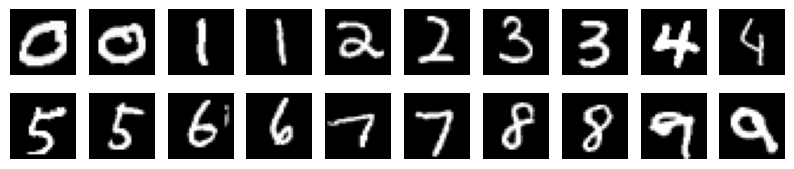

In [24]:
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(2, 10, i*2+1)
    plt.imshow(X[i*class_size][0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 10, i*2+2)
    plt.imshow(Y[i*class_size][0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

plt.show()

## Train the model

:::{tip} Question: **How to implements the mutual information estimate?**

We will maximize DV lower bound as the example to estimate the mutual information between $X$ and $Y$. The empirical DV lower bound is

$$
\sup_{f_{\theta}:\mathcal{X}\times\mathcal{Y}\rightarrow \mathbb{R}} \frac{1}{n}\sum_{i\in [n]} f_{\theta}(X_i, Y_i) - \log \frac{1}{n'}\sum_{i\in [n']} e^{ f_{\theta}(X'_i, Y'_i)},
$$
where
- the supremum is over $f_{\theta}$ represented by a neural network with trainable/optimizable parameters $\theta$;
- $P_{X'Y'} := P_XP_Y$;
- $X'_i$ and $Y'_i$ are i.i.d. samples from $P_{X'Y'}$.

:::{tip} Question: **How to get the samples from $P_{X'Y'}$?**

Given $n$ samples $\{X_i,Y_i\}_{i\in[n]}\sim P_{XY}$, we can reshuflle the samples ${X_i}_{i\in[n]}$, ${Y_i}_{i\in[n]}$ and concatenate them together to get samples $\{X'_i,Y'_i\}_{i\in[n^2]}\sim P_{X'Y'}$. We can also draw a new reference batch of samples $\{Y'_i\}_{i\in[m]}$ and apply the reshuflling trick to get $\{X'_i,Y'_i\}_{i\in[mn]}\sim P_{X'Y'}$. This is illustrated by the figure below.

<img src="./figs/reshuffling.png" alt="shuffle" width="800" height="500">

:::{note} **Regularization**

Since the original objective function has drifting issue, we can add a regularization term to avoid the output of the neural network drifting to infinity. The regularized loss function is

$$
L_{\text{DV}}(\theta) = -\frac{1}{n}\sum_{i\in [n]} f_{\theta}(X_i, Y_i) + \log \frac{1}{n'}\sum_{i\in [n']} e^{ f_{\theta}(X'_i, Y'_i)} + \lambda \bigg(\log \frac{1}{n'}\sum_{i\in [n']} e^{ f_{\theta}(X'_i, Y'_i)}\bigg)^2,
$$
where $\lambda>0$ is a hyperparameter to control the weight of regularization.

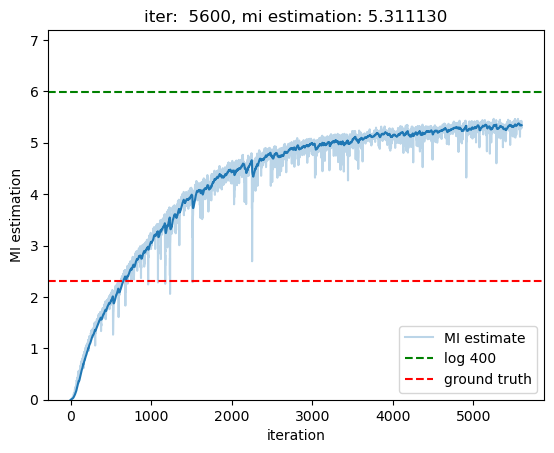

In [25]:
# set the training parameters
max_iter = 6000 # maximum number of iterations
batch_size = 40 # batch size in the mini-batch training
ref_batch_size = batch_size # size for the reference batch if refbatch is True

# if the loaded results are not enough, continue training
continue_train = True
if continue_train:
    current_iter = len(mi_list)
    print('Continue training from previous results, start from iter: ', current_iter)
    for i in range(max_iter-len(mi_list)):
        # draw mini-batch data; idx is the index of the mini-batch data
        idx = resample(X, batch_size, return_idx=True)

        # train
        optimizer.zero_grad()
        if refbatch: # use a different batch as the reference
            # select a different batch as the reference
            idx_ref = resample(Y, ref_batch_size, return_idx=True)
            loss = eval(loss_fn)(net, X[idx], Y[idx], Y[idx_ref], reg=reg)
        else: # Do not use new reference batch
            loss = eval(loss_fn)(net, X[idx], Y[idx], reg=reg)
        loss.backward()
        optimizer.step()

        # calculate the MI
        with torch.no_grad():
            if miest_type == 'all': # estimate mi with the loss objective
                mi_list.append(-eval(loss_fn)(net, X, Y).item())
            elif miest_type == 'l1': # estimate mi with the average of net(XY) if net converges to the density ratio
                mi_list.append(mi_estimate(net, XY).item())

        # plot the MI estimation and the ground truth
        if i % 400 == 0:
            plt.clf()
            EMA_SPAN = 50
            p1 = plt.plot(mi_list, alpha=0.3, label='MI estimate')[0]
            mis_smooth = pd.Series(mi_list).ewm(span=EMA_SPAN).mean()
            plt.plot(mis_smooth, c=p1.get_color())
            plt.axhline(math.log(XY.shape[0]), c='g', ls='--', label=f'log {XY.shape[0]}')
            plt.axhline(math.log(test_labels), c='r', ls='--', label='ground truth')
            plt.ylim(0, 1.2*math.log(XY.shape[0]))
            plt.xlabel('iteration')
            plt.ylabel('MI estimation')
            plt.title(f'iter: {i+current_iter:5d}, mi estimation: {mi_list[-1]:4f}')
            plt.legend()

            display.clear_output(wait=True)
            display.display(plt.gcf())
    display.clear_output()

Save current results.

In [26]:
overwrite = False  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    torch.save({
        'mi_list': mi_list,
        'net_state_list': net.state_dict(),
        'optimizer_state_list': optimizer.state_dict(),
    }, chkpt_name)
    print('Current results saved.')

Current results saved.
